In [1]:
import torch
import yaml
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict

In [2]:
def setup_logging(log_dir: Path):
    """Setup logging configuration"""
    log_dir.mkdir(parents=True, exist_ok=True)
    logging.basicConfig(
        filename=log_dir / 'pipeline.log',
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )


In [3]:

def load_config(config_path: str) -> Dict:
    """Load and validate configuration"""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    required_keys = [
        'data_path', 'model_name', 'num_labels', 'batch_size',
        'learning_rate', 'num_epochs'
    ]
    
    for key in required_keys:
        if key not in config:
            raise ValueError(f"Missing required config key: {key}")
    
    return config


In [4]:
import wandb


config_path = "config.yaml"

"""Run complete training pipeline"""
# Load configuration
config = load_config(config_path)

# Setup paths and logging
base_path = Path(config['data_path'])
experiment_name = f"vit_constellation_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
output_dir = Path('experiments') / experiment_name
output_dir.mkdir(parents=True, exist_ok=True)
if config.get('wandb', {}).get('use_wandb', False):
    wandb.init(
        project=config['wandb']['project'],
        name=experiment_name,
        config=config
    )
setup_logging(output_dir)
logging.info("Starting pipeline execution")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arsive. Use `wandb login --relogin` to force relogin


Data directory: E:\University\CU_Classes\Year-1\Fall 2024\CSCI_5502_Data Mining\Milestone_project\stellar_mapping\data\constellation_dataset_1
Number of image files in DataFrame: 1641


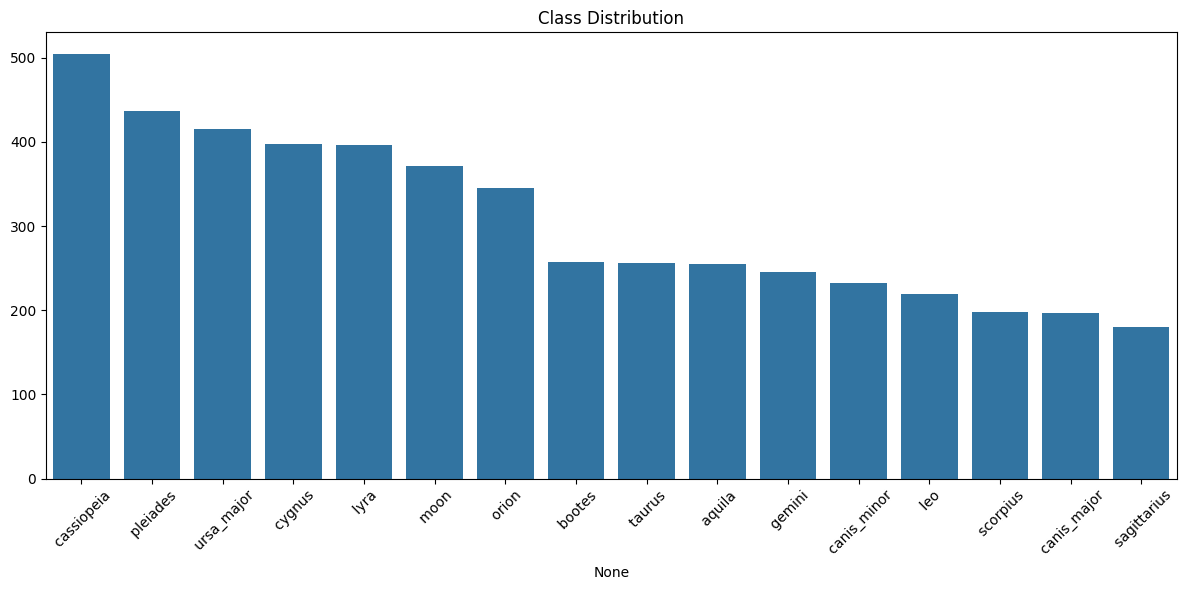

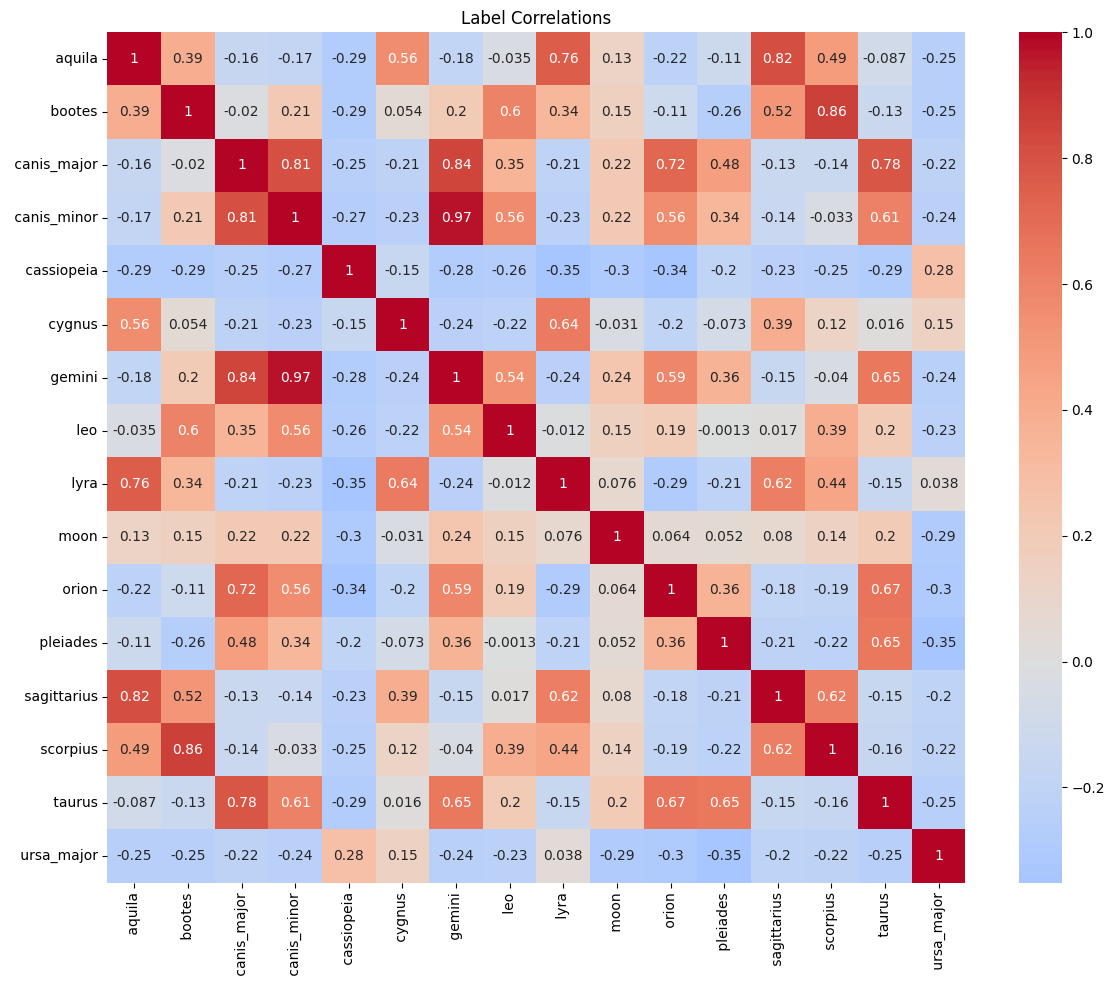

In [5]:
# 1. Run EDA
logging.info("Running Exploratory Data Analysis...")
from EDA import ConstellationEDA
eda = ConstellationEDA(
    data_dir=str(base_path)
)
eda_report = eda.generate_report()


In [6]:

# Update config with EDA recommendations
config.update(eda_report['recommendations'])

train_csv = base_path / 'train' / '_classes.csv'
train_img_dir = base_path / 'train' / 'images'
val_csv = base_path / 'valid' / '_classes.csv'
val_img_dir = base_path / 'valid' / 'images'
test_csv = base_path / 'test' / '_classes.csv'
test_img_dir = base_path / 'test' / 'images'

# 2. Setup Data Module
logging.info("Setting up data preprocessing...")
from data_preprocessing import DataModule
data_module = DataModule(
    train_csv=train_csv,
    train_img_dir=train_img_dir,
    val_csv=val_csv,
    val_img_dir=val_img_dir,
    batch_size=config['batch_size'],
    model_name=config['model_name']
)
data_module.setup()
train_loader, val_loader = data_module.get_dataloaders()


In [7]:

# 3. Create Model
logging.info("Creating model...")
from vit_model import create_model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(config)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:

# 4. Training
logging.info("Starting training...")
from vit_trainer import Trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config={**config, 'save_dir': str(output_dir / 'checkpoints')},
    device=device
)
trainer.train()



Epoch 1/10


Training: 100%|██████████| 52/52 [00:50<00:00,  1.02it/s, loss=0.617]


Train metrics: {'map': 0.14936503835095355, 'exact_match': 0.0030469226081657527, 'hamming_loss': 0.2901432053625838, 'per_class_metrics': {'class_0': {'precision': 0.19557195571955718, 'recall': 0.41568627450980394, 'f1': 0.26599749058971145}, 'class_1': {'precision': 0.15056461731493098, 'recall': 0.4669260700389105, 'f1': 0.22770398481973433}, 'class_2': {'precision': 0.0, 'recall': 0.0, 'f1': 0}, 'class_3': {'precision': 0.16666666666666666, 'recall': 0.02145922746781116, 'f1': 0.038022813688212934}, 'class_4': {'precision': 0.26778242677824265, 'recall': 0.12673267326732673, 'f1': 0.17204301075268816}, 'class_5': {'precision': 0.23636363636363636, 'recall': 0.1309823677581864, 'f1': 0.1685575364667747}, 'class_6': {'precision': 0.0, 'recall': 0.0, 'f1': 0}, 'class_7': {'precision': 0.1232876712328767, 'recall': 0.0410958904109589, 'f1': 0.06164383561643835}, 'class_8': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_9': {'precision': 0.1945945945945946, 'recall': 0.09677419354838

Validation: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


Validation metrics: {'map': 0.0, 'exact_match': 0.0, 'hamming_loss': 0.19722814498933902, 'per_class_metrics': {'class_0': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_3': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_9': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_10': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_11': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_12': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_13': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_14': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_15': {'precision': 0, 'recall': 0.0, 'f1': 0}}, 'loss': 0.626845649878184}
Saved 

Training: 100%|██████████| 52/52 [00:51<00:00,  1.02it/s, loss=0.547]


Train metrics: {'map': 0.0, 'exact_match': 0.001218769043266301, 'hamming_loss': 0.186966788543571, 'per_class_metrics': {'class_0': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_3': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_9': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_10': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_11': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_12': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_13': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_14': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_15': {'precision': 0, 'recall': 0.0, 'f1': 0}}, 'loss': 0.5807121854562

Validation: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


Validation metrics: {'map': 0.0, 'exact_match': 0.0, 'hamming_loss': 0.19722814498933902, 'per_class_metrics': {'class_0': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_3': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_9': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_10': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_11': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_12': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_13': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_14': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_15': {'precision': 0, 'recall': 0.0, 'f1': 0}}, 'loss': 0.5475727915763855}
Saved

Training: 100%|██████████| 52/52 [08:36<00:00,  9.94s/it, loss=0.473]  


Train metrics: {'map': 0.0625, 'exact_match': 0.001218769043266301, 'hamming_loss': 0.18692870201096892, 'per_class_metrics': {'class_0': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_3': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_9': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_10': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_11': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_12': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_13': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_14': {'precision': 1.0, 'recall': 0.00390625, 'f1': 0.007782101167315175}, 'class_15': {'precision': 0, 'recall': 0.0, '

Validation: 100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


Validation metrics: {'map': 0.0, 'exact_match': 0.0, 'hamming_loss': 0.19722814498933902, 'per_class_metrics': {'class_0': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_3': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_9': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_10': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_11': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_12': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_13': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_14': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_15': {'precision': 0, 'recall': 0.0, 'f1': 0}}, 'loss': 0.48097938696543374}
Save

Training: 100%|██████████| 52/52 [01:37<00:00,  1.87s/it, loss=0.419]


Train metrics: {'map': 0.5354761742957246, 'exact_match': 0.0042656916514320535, 'hamming_loss': 0.17264625228519195, 'per_class_metrics': {'class_0': {'precision': 1.0, 'recall': 0.03529411764705882, 'f1': 0.06818181818181818}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 1.0, 'recall': 0.07614213197969544, 'f1': 0.14150943396226415}, 'class_3': {'precision': 0.9538461538461539, 'recall': 0.26609442060085836, 'f1': 0.4161073825503356}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 1.0, 'recall': 0.25203252032520324, 'f1': 0.4025974025974026}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 1.0, 'recall': 0.1111111111111111, 'f1': 0.19999999999999998}, 'class_9': {'precision': 0.8333333333333334, 'recall': 0.013440860215053764, 'f1': 0.026455026455026454}, 'class_10': {'precision': 0.975609756097561, 'recall': 0.11594202898550725, 'f1': 0.2

Validation: 100%|██████████| 15/15 [00:51<00:00,  3.42s/it]


Validation metrics: {'map': 0.362155410823005, 'exact_match': 0.0021321961620469083, 'hamming_loss': 0.15591684434968017, 'per_class_metrics': {'class_0': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_3': {'precision': 0.9841269841269841, 'recall': 0.7294117647058823, 'f1': 0.8378378378378377}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 1.0, 'recall': 0.6847826086956522, 'f1': 0.8129032258064516}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 1.0, 'recall': 0.1415929203539823, 'f1': 0.24806201550387597}, 'class_9': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_10': {'precision': 1.0, 'recall': 0.5959595959595959, 'f1': 0.7468354430379746}, 'class_11': {'precision': 0.90625, 'recall': 0.43609022556390975, 'f1': 0.5888324873096447}, 'class_12': {'precision': 0

Training: 100%|██████████| 52/52 [01:43<00:00,  1.98s/it, loss=0.42] 


Train metrics: {'map': 0.5031159526132771, 'exact_match': 0.019500304692260818, 'hamming_loss': 0.15055606337599026, 'per_class_metrics': {'class_0': {'precision': 0.9649122807017544, 'recall': 0.21568627450980393, 'f1': 0.3525641025641026}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.9891304347826086, 'recall': 0.4619289340101523, 'f1': 0.629757785467128}, 'class_3': {'precision': 0.926829268292683, 'recall': 0.6523605150214592, 'f1': 0.7657430730478589}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0.95625, 'recall': 0.6219512195121951, 'f1': 0.7536945812807881}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.9865771812080537, 'recall': 0.3712121212121212, 'f1': 0.5394495412844037}, 'class_9': {'precision': 0.5416666666666666, 'recall': 0.03494623655913978, 'f1': 0.06565656565656566}, 'class_10': {'precision': 0.9473684210526315, '

Validation: 100%|██████████| 15/15 [00:45<00:00,  3.02s/it]


Validation metrics: {'map': 0.5294433752656587, 'exact_match': 0.0511727078891258, 'hamming_loss': 0.1333955223880597, 'per_class_metrics': {'class_0': {'precision': 0.9014084507042254, 'recall': 0.9411764705882353, 'f1': 0.920863309352518}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 1.0, 'recall': 0.7536231884057971, 'f1': 0.859504132231405}, 'class_3': {'precision': 0.9428571428571428, 'recall': 0.7764705882352941, 'f1': 0.8516129032258064}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0.9857142857142858, 'recall': 0.75, 'f1': 0.8518518518518519}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.9240506329113924, 'recall': 0.6460176991150443, 'f1': 0.7604166666666666}, 'class_9': {'precision': 1.0, 'recall': 0.009009009009009009, 'f1': 0.01785714285714286}, 'class_10': {'precision': 0.9571428571428572, 'recall': 0.6767676767676768, 'f

Training: 100%|██████████| 52/52 [01:33<00:00,  1.79s/it, loss=0.442]


Train metrics: {'map': 0.6224531184733793, 'exact_match': 0.02437538086532602, 'hamming_loss': 0.14103443022547227, 'per_class_metrics': {'class_0': {'precision': 0.9426751592356688, 'recall': 0.5803921568627451, 'f1': 0.7184466019417477}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.9615384615384616, 'recall': 0.6345177664974619, 'f1': 0.764525993883792}, 'class_3': {'precision': 0.9488636363636364, 'recall': 0.7167381974248928, 'f1': 0.8166259168704157}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 1.0, 'recall': 0.0025188916876574307, 'f1': 0.005025125628140703}, 'class_6': {'precision': 0.9608938547486033, 'recall': 0.6991869918699187, 'f1': 0.8094117647058823}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.958139534883721, 'recall': 0.5202020202020202, 'f1': 0.67430441898527}, 'class_9': {'precision': 0.6530612244897959, 'recall': 0.08602150537634409, 'f1': 0.15201900237529692}, '

Validation: 100%|██████████| 15/15 [00:57<00:00,  3.82s/it]


Validation metrics: {'map': 0.5232879120110608, 'exact_match': 0.05543710021321962, 'hamming_loss': 0.13286247334754797, 'per_class_metrics': {'class_0': {'precision': 0.9411764705882353, 'recall': 0.7058823529411765, 'f1': 0.8067226890756304}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.9682539682539683, 'recall': 0.8840579710144928, 'f1': 0.9242424242424243}, 'class_3': {'precision': 0.9090909090909091, 'recall': 0.8235294117647058, 'f1': 0.8641975308641976}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0.987012987012987, 'recall': 0.8260869565217391, 'f1': 0.8994082840236687}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.958904109589041, 'recall': 0.6194690265486725, 'f1': 0.7526881720430106}, 'class_9': {'precision': 1.0, 'recall': 0.036036036036036036, 'f1': 0.06956521739130435}, 'class_10': {'precision': 0.9090909090909091, '

Training: 100%|██████████| 52/52 [01:42<00:00,  1.96s/it, loss=0.364]


Train metrics: {'map': 0.6500384899635467, 'exact_match': 0.028031687995124923, 'hamming_loss': 0.1380255941499086, 'per_class_metrics': {'class_0': {'precision': 0.9368421052631579, 'recall': 0.6980392156862745, 'f1': 0.7999999999999999}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.9536423841059603, 'recall': 0.7309644670050761, 'f1': 0.8275862068965517}, 'class_3': {'precision': 0.898936170212766, 'recall': 0.7253218884120172, 'f1': 0.8028503562945368}, 'class_4': {'precision': 0.7272727272727273, 'recall': 0.015841584158415842, 'f1': 0.0310077519379845}, 'class_5': {'precision': 0.9565217391304348, 'recall': 0.055415617128463476, 'f1': 0.10476190476190476}, 'class_6': {'precision': 0.9417989417989417, 'recall': 0.7235772357723578, 'f1': 0.8183908045977011}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.9533898305084746, 'recall': 0.5681818181818182, 'f1': 0.7120253164556962}, 'class_9': {'precision': 0.57303370786

Validation: 100%|██████████| 15/15 [00:51<00:00,  3.46s/it]


Validation metrics: {'map': 0.4758742771053398, 'exact_match': 0.06183368869936034, 'hamming_loss': 0.13446162046908317, 'per_class_metrics': {'class_0': {'precision': 0.9387755102040817, 'recall': 0.6764705882352942, 'f1': 0.7863247863247864}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.8904109589041096, 'recall': 0.9420289855072463, 'f1': 0.9154929577464788}, 'class_3': {'precision': 0.8681318681318682, 'recall': 0.9294117647058824, 'f1': 0.8977272727272727}, 'class_4': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_5': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_6': {'precision': 0.945054945054945, 'recall': 0.9347826086956522, 'f1': 0.9398907103825138}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.9841269841269841, 'recall': 0.5486725663716814, 'f1': 0.7045454545454545}, 'class_9': {'precision': 0.6190476190476191, 'recall': 0.11711711711711711, 'f1': 0.19696969696969696}, 'class_10': {'precision': 0.8131

Training: 100%|██████████| 52/52 [01:34<00:00,  1.82s/it, loss=0.372]


Train metrics: {'map': 0.6451551028214746, 'exact_match': 0.032297379646556976, 'hamming_loss': 0.13604509445460086, 'per_class_metrics': {'class_0': {'precision': 0.9138755980861244, 'recall': 0.7490196078431373, 'f1': 0.8232758620689654}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.9625, 'recall': 0.7817258883248731, 'f1': 0.8627450980392157}, 'class_3': {'precision': 0.9234972677595629, 'recall': 0.7253218884120172, 'f1': 0.8125}, 'class_4': {'precision': 0.7272727272727273, 'recall': 0.047524752475247525, 'f1': 0.08921933085501858}, 'class_5': {'precision': 0.8852459016393442, 'recall': 0.13602015113350127, 'f1': 0.23580786026200878}, 'class_6': {'precision': 0.9565217391304348, 'recall': 0.7154471544715447, 'f1': 0.8186046511627906}, 'class_7': {'precision': 0.0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.9297520661157025, 'recall': 0.5681818181818182, 'f1': 0.7053291536050157}, 'class_9': {'precision': 0.5529411764705883, 'recall': 0.1

Validation: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Validation metrics: {'map': 0.6143428922739852, 'exact_match': 0.04051172707889126, 'hamming_loss': 0.13499466950959488, 'per_class_metrics': {'class_0': {'precision': 0.9272727272727272, 'recall': 0.75, 'f1': 0.8292682926829268}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.8589743589743589, 'recall': 0.9710144927536232, 'f1': 0.9115646258503401}, 'class_3': {'precision': 0.8695652173913043, 'recall': 0.9411764705882353, 'f1': 0.903954802259887}, 'class_4': {'precision': 1.0, 'recall': 0.006578947368421052, 'f1': 0.013071895424836602}, 'class_5': {'precision': 0.5, 'recall': 0.030303030303030304, 'f1': 0.05714285714285715}, 'class_6': {'precision': 0.9456521739130435, 'recall': 0.9456521739130435, 'f1': 0.9456521739130435}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.9577464788732394, 'recall': 0.6017699115044248, 'f1': 0.7391304347826088}, 'class_9': {'precision': 0.4339622641509434, 'recall': 0.2072072072072072, 

Training: 100%|██████████| 52/52 [00:50<00:00,  1.03it/s, loss=0.411]


Train metrics: {'map': 0.6686974814583102, 'exact_match': 0.05301645338208409, 'hamming_loss': 0.12922760511882997, 'per_class_metrics': {'class_0': {'precision': 0.9321266968325792, 'recall': 0.807843137254902, 'f1': 0.865546218487395}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.9298245614035088, 'recall': 0.8071065989847716, 'f1': 0.8641304347826086}, 'class_3': {'precision': 0.8910891089108911, 'recall': 0.7725321888412017, 'f1': 0.8275862068965517}, 'class_4': {'precision': 0.672514619883041, 'recall': 0.22772277227722773, 'f1': 0.3402366863905326}, 'class_5': {'precision': 0.8034188034188035, 'recall': 0.2367758186397985, 'f1': 0.3657587548638132}, 'class_6': {'precision': 0.9306930693069307, 'recall': 0.7642276422764228, 'f1': 0.8392857142857143}, 'class_7': {'precision': 0.6, 'recall': 0.0136986301369863, 'f1': 0.026785714285714288}, 'class_8': {'precision': 0.9545454545454546, 'recall': 0.5833333333333334, 'f1': 0.7241379310344828}, 'class_9

Validation: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Validation metrics: {'map': 0.63978444412536, 'exact_match': 0.053304904051172705, 'hamming_loss': 0.12979744136460555, 'per_class_metrics': {'class_0': {'precision': 0.8805970149253731, 'recall': 0.8676470588235294, 'f1': 0.874074074074074}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.9041095890410958, 'recall': 0.9565217391304348, 'f1': 0.9295774647887325}, 'class_3': {'precision': 0.8987341772151899, 'recall': 0.8352941176470589, 'f1': 0.8658536585365854}, 'class_4': {'precision': 1.0, 'recall': 0.06578947368421052, 'f1': 0.12345679012345677}, 'class_5': {'precision': 0.5625, 'recall': 0.09090909090909091, 'f1': 0.1565217391304348}, 'class_6': {'precision': 0.975, 'recall': 0.8478260869565217, 'f1': 0.9069767441860466}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.9240506329113924, 'recall': 0.6460176991150443, 'f1': 0.7604166666666666}, 'class_9': {'precision': 0.5263157894736842, 'recall': 0.18018018018018017, 

Training: 100%|██████████| 52/52 [00:51<00:00,  1.01it/s, loss=0.307]


Train metrics: {'map': 0.6728725621884005, 'exact_match': 0.04692260816575259, 'hamming_loss': 0.13090341255332114, 'per_class_metrics': {'class_0': {'precision': 0.9324324324324325, 'recall': 0.8117647058823529, 'f1': 0.8679245283018868}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.9235294117647059, 'recall': 0.7969543147208121, 'f1': 0.8555858310626702}, 'class_3': {'precision': 0.8994974874371859, 'recall': 0.7682403433476395, 'f1': 0.8287037037037037}, 'class_4': {'precision': 0.6586538461538461, 'recall': 0.2712871287128713, 'f1': 0.3842917251051894}, 'class_5': {'precision': 0.7570093457943925, 'recall': 0.2040302267002519, 'f1': 0.32142857142857145}, 'class_6': {'precision': 0.9353233830845771, 'recall': 0.7642276422764228, 'f1': 0.8411633109619686}, 'class_7': {'precision': 0.75, 'recall': 0.0136986301369863, 'f1': 0.026905829596412554}, 'class_8': {'precision': 0.933852140077821, 'recall': 0.6060606060606061, 'f1': 0.7350689127105666}, 'clas

Validation: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]

Validation metrics: {'map': 0.6264731969997435, 'exact_match': 0.04904051172707889, 'hamming_loss': 0.12819829424307036, 'per_class_metrics': {'class_0': {'precision': 0.9016393442622951, 'recall': 0.8088235294117647, 'f1': 0.8527131782945736}, 'class_1': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_2': {'precision': 0.881578947368421, 'recall': 0.9710144927536232, 'f1': 0.9241379310344827}, 'class_3': {'precision': 0.8809523809523809, 'recall': 0.8705882352941177, 'f1': 0.8757396449704142}, 'class_4': {'precision': 0.8181818181818182, 'recall': 0.17763157894736842, 'f1': 0.29189189189189185}, 'class_5': {'precision': 0.6521739130434783, 'recall': 0.15151515151515152, 'f1': 0.2459016393442623}, 'class_6': {'precision': 0.9759036144578314, 'recall': 0.8804347826086957, 'f1': 0.9257142857142858}, 'class_7': {'precision': 0, 'recall': 0.0, 'f1': 0}, 'class_8': {'precision': 0.9594594594594594, 'recall': 0.6283185840707964, 'f1': 0.7593582887700534}, 'class_9': {'precision': 0.48780487

In [9]:

# 5. Evaluation
logging.info("Running evaluation...")
from evaluation import ModelEvaluator

# Load best model
best_model = create_model(config)
checkpoint = torch.load(
    output_dir / 'checkpoints/best_model.pt',
    map_location=device
)
best_model.load_state_dict(checkpoint['model_state_dict'])


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sivap\AppData\Local\Temp\ipykernel_51776\113994834.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor

<All keys matched successfully>

In [10]:

# Create test dataloader
test_module = DataModule(
    train_csv=str(train_csv),  # Not used but needed for initialization
    train_img_dir=str(train_img_dir),  # Not used but needed for initialization
    val_csv=str(val_csv),
    val_img_dir=str(val_img_dir),
    batch_size=config['batch_size'],
    model_name=config['model_name']
)
test_module.setup()
_, test_loader = test_module.get_dataloaders()

# Run evaluation
evaluator = ModelEvaluator(
    model=best_model,
    test_loader=test_loader,
    class_names=data_module.get_class_names(),
    device=device,
    output_dir=str(output_dir / 'evaluation')
)
evaluation_results = evaluator.evaluate()

logging.info("Pipeline completed successfully")
logging.info(f"Results saved in {output_dir}")

{
    'output_dir': output_dir,
    'evaluation_results': evaluation_results,
    'eda_report': eda_report
}

{'output_dir': WindowsPath('experiments/vit_constellation_20241120_161644'),
 'evaluation_results': {'overall_metrics': {'exact_match': 0.053304904051172705,
   'hamming_loss': 0.12979744136460555,
   'precision': 0.07955756929637527,
   'recall': 0.013617340592701158,
   'f1_score': 0.023254382922681154},
  'per_class_metrics': {' aquila': {'precision': 0.0018776055755310424,
    'recall': 0.001849993728832097,
    'f1_score': 0.0018636973360854295,
    'auc': 0.9919686078920346},
   ' bootes': {'precision': 0.0,
    'recall': 0.0,
    'f1_score': 0.0,
    'auc': 0.9304272130708451},
   ' canis_major': {'precision': 0.0019277389958205914,
    'recall': 0.0020394919810853914,
    'f1_score': 0.0019820414527847146,
    'auc': 0.9980434782608696},
   ' canis_minor': {'precision': 0.0019162775633561882,
    'recall': 0.0017810109118253223,
    'f1_score': 0.0018461697976906559,
    'auc': 0.9948529411764706},
   ' cassiopeia': {'precision': 0.0021321961620255864,
    'recall': 0.000140276